<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task5_model_training_and_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

合格的深度学习训练流程至少具备以下功能：

+ 在训练集上进行训练，并在验证集上进行验证；
+ 模型可以保存最优的权重，并读取权重；
+ 记录下训练集和验证集的精度，便于调参。

模型训练与验证
+ 为此本章将从构建验证集、模型训练和验证、模型保存与加载和模型调参几个部分讲解，在部分小节中将会结合Pytorch代码进行讲解。

任务目标
+ 理解验证集的作用，并使用训练集和验证集完成训练
+ 学会使用Pytorch环境下的模型读取和加载，并了解调参流程

构造验证集

在机器学习模型（特别是深度学习模型）的训练过程中，模型是非常容易过拟合的。深度学习模型在不断的训练过程中训练误差会逐渐降低，但测试误差的走势则不一定。

在模型的训练过程中，模型只能利用训练数据来进行训练，模型并不能接触到测试集上的样本。因此模型如果将训练集学的过好，模型就会记住训练样本的细节，导致模型在测试集的泛化效果较差，这种现象称为过拟合（Overfitting）。与过拟合相对应的是欠拟合（Underfitting），即模型在训练集上的拟合效果较差。

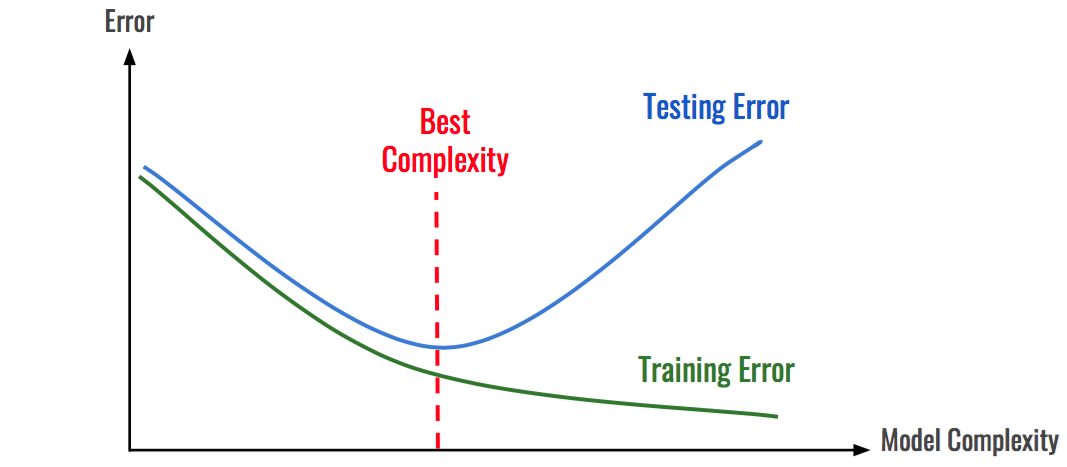


如图所示：随着模型复杂度和模型训练轮数的增加，CNN模型在训练集上的误差会降低，但在测试集上的误差会逐渐降低，然后逐渐升高，而我们为了追求的是模型在测试集上的精度越高越好。

导致模型过拟合的情况有很多种原因，其中最为常见的情况是模型复杂度（Model Complexity ）太高，导致模型学习到了训练数据的方方面面，学习到了一些细枝末节的规律。

解决上述问题最好的解决方法：构建一个与测试集尽可能分布一致的样本集（可称为验证集），在训练过程中不断验证模型在验证集上的精度，并以此控制模型的训练。

在给定赛题后，赛题方会给定训练集和测试集两部分数据。参赛者需要在训练集上面构建模型，并在测试集上面验证模型的泛化能力。因此参赛者可以通过提交模型对测试集的预测结果，来验证自己模型的泛化能力。同时参赛方也会限制一些提交的次数限制，以此避免参赛选手“刷分”。

在一般情况下，参赛选手也可以自己在本地划分出一个验证集出来，进行本地验证。训练集、验证集和测试集分别有不同的作用：

+ 训练集（Train Set）：模型用于训练和调整模型参数；
+ 验证集（Validation Set）：用来验证模型精度和调整模型超参数；
+ 测试集（Test Set）：验证模型的泛化能力。

因为训练集和验证集是分开的，所以模型在验证集上面的精度在一定程度上可以反映模型的泛化能力。在划分验证集的时候，需要注意验证集的分布应该与测试集尽量保持一致，不然模型在验证集上的精度就失去了指导意义。

既然验证集这么重要，那么如何划分本地验证集呢。在一些比赛中，赛题方会给定验证集；如果赛题方没有给定验证集，那么参赛选手就需要从训练集中拆分一部分得到验证集。验证集的划分有如下几种方式：
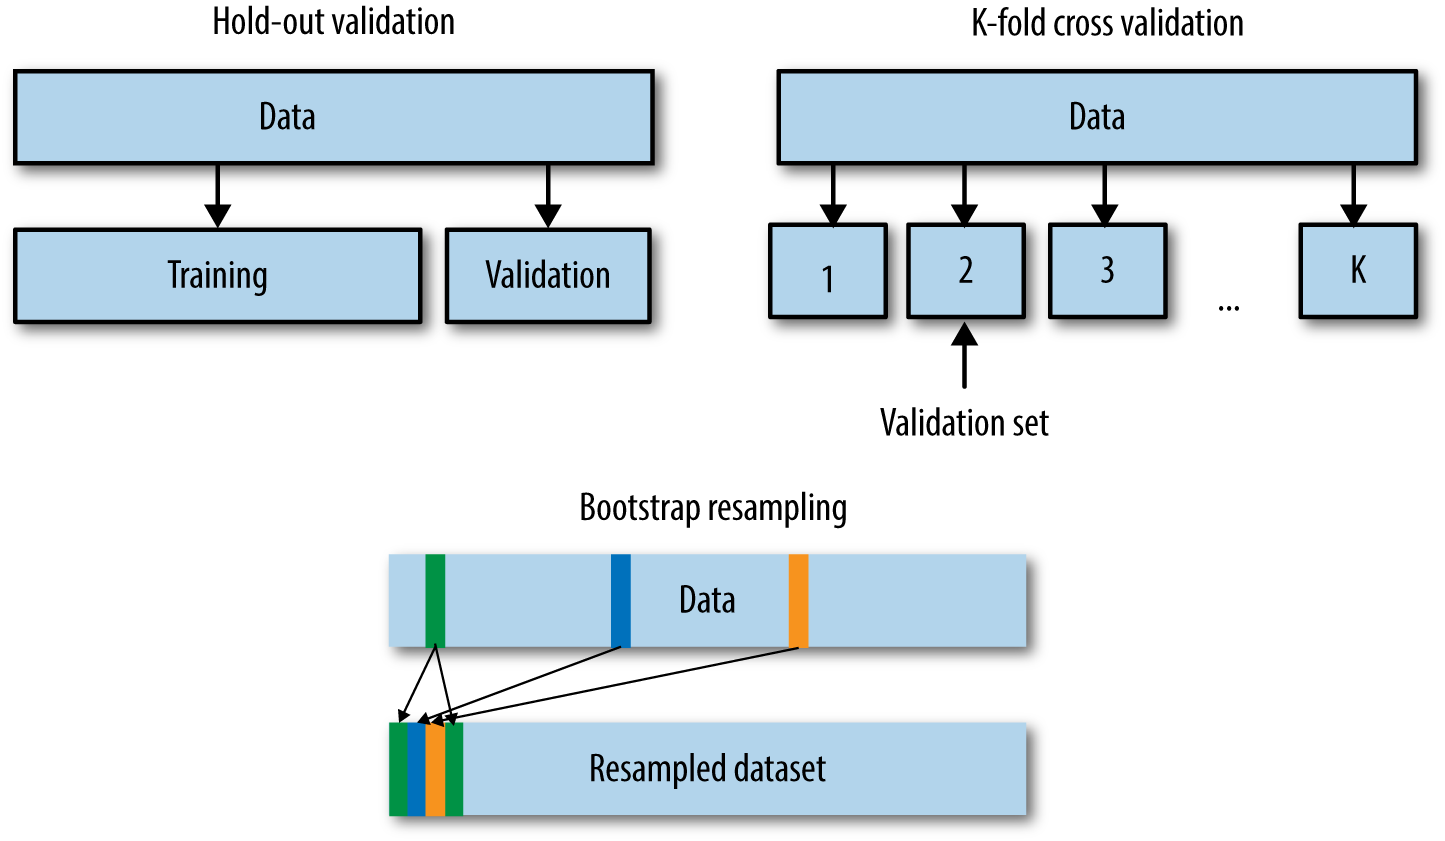

留出法（Hold-Out）

直接将训练集划分成两部分，新的训练集和验证集。这种划分方式的优点是最为直接简单；缺点是只得到了一份验证集，有可能导致模型在验证集上过拟合。留出法应用场景是数据量比较大的情况。

交叉验证法（Cross Validation，CV）

将训练集划分成K份，将其中的K-1份作为训练集，剩余的1份作为验证集，循环K训练。这种划分方式是所有的训练集都是验证集，最终模型验证精度是K份平均得到。这种方式的优点是验证集精度比较可靠，训练K次可以得到K个有多样性差异的模型；CV验证的缺点是需要训练K次，不适合数据量很大的情况。

自助采样法（BootStrap）

通过有放回的采样方式得到新的训练集和验证集，每次的训练集和验证集都是有区别的。这种划分方式一般适用于数据量较小的情况。

在本次赛题中已经划分为验证集，因此选手可以直接使用训练集进行训练，并使用验证集进行验证精度（当然你也可以合并训练集和验证集，自行划分验证集）。

当然这些划分方法是从数据划分方式的角度来讲的，在现有的数据比赛中一般采用的划分方法是留出法和交叉验证法。如果数据量比较大，留出法还是比较合适的。当然任何的验证集的划分得到的验证集都是要保证训练集-验证集-测试集的分布是一致的，所以如果不管划分何种的划分方式都是需要注意的。

这里的分布一般指的是与标签相关的统计分布，比如在分类任务中“分布”指的是标签的类别分布，训练集-验证集-测试集的类别分布情况应该大体一致；如果标签是带有时序信息，则验证集和测试集的时间间隔应该保持一致。

5.3 模型训练与验证
在本节我们目标使用Pytorch来完成CNN的训练和验证过程，CNN网络结构与之前的章节中保持一致。我们需要完成的逻辑结构如下：

+ 构造训练集和验证集；
+ 每轮进行训练和验证，并根据最优验证集精度保存模型。



```
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=10, 
  shuffle=True, 
  num_workers=10, 
)

val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=10, 
  shuffle=False, 
  num_workers=10, 
)

model = Model1()
criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0
for epoch in range(20):
  print('Epoch: ', epoch)

train(train_loader, model, criterion, optimizer, epoch)
val_loss = validate(val_loader, model, criterion)

# 记录下验证集精度
if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), './model.pt')
```



5.4 模型保存与加载

在Pytorch中模型的保存和加载非常简单，比较常见的做法是保存和加载模型参数： 

```
torch.save(model_object.state_dict(), 'model.pt')

model.load_state_dict(torch.load(' model.pt'))
```



5.5 模型调参流程
深度学习原理少但实践性非常强，基本上很多的模型的验证只能通过训练来完成。同时深度学习有众多的网络结构和超参数，因此需要反复尝试。训练深度学习模型需要GPU的硬件支持，也需要较多的训练时间，如何有效的训练深度学习模型逐渐成为了一门学问。